<h1>This is the notebook for DriftNet paper </h1>
<h2>The notebook includes the exploration of the datasetr, the pre-trained model application on the test dataset and the evaluation metrics calculation

In [54]:
import xarray as xr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pytorch_lightning as pl

import scipy.integrate as integrate

import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

<h3> OSSE framework

In [2]:
data = np.loadtxt('/home/daria/Documents/These/DATA/TEST_processed_DATASET_Pacific.txt')

In [3]:
data = pd.read_csv('/home/daria/Documents/These/DATA/TEST_filenames_correct_DATASET_Pacific_9days.csv')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]
data

,NatRun_3nadir_lon,NatRun_3nadir_lat,date,NatRun_lon,NatRun_lat,id_drifter,filename
0,-143.00000,23.750000,2015-03-22 00:00:00,-143.00000,23.750000,2275,0
1,-142.92950,23.791424,2015-03-22 06:00:00,-142.94972,23.796007,2275,0
2,-142.85336,23.825947,2015-03-22 12:00:00,-142.89407,23.841460,2275,0
3,-142.77380,23.854317,2015-03-22 18:00:00,-142.83319,23.886003,2275,0
4,-142.69144,23.874666,2015-03-23 00:00:00,-142.76581,23.929937,2275,0
...,...,...,...,...,...,...,...
25895,-129.77115,32.816630,2015-09-03 00:00:00,-129.89597,32.961143,6649,699
25896,-129.73657,32.814735,2015-09-03 06:00:00,-129.88759,32.956040,6649,699
25897,-129.70126,32.814735,2015-09-03 12:00:00,-129.87917,32.951515,6649,699
25898,-129.66528,32.816658,2015-09-03 18:00:00,-129.87074,32.947567,6649,699


Text(0.5, 1.0, 'Deployment locations of virtual particles \n advected from partially observed (OSSE) fields')

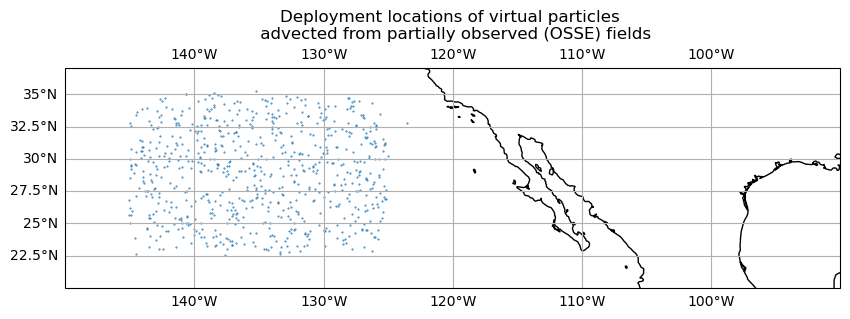

In [4]:
plt.figure(figsize = (10, 5))
projection = ccrs.PlateCarree(central_longitude=-50.0)
ax = plt.axes(projection = projection)
ax.coastlines()
ax.set_extent([-150, -90, 20, 37], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels = True)
gl.right_labels = False

ax = plt.scatter(np.array(data['NatRun_3nadir_lon'])[::36], np.array(data['NatRun_3nadir_lat'])[::36], transform = ccrs.PlateCarree(), s = 0.2)
plt.title('Deployment locations of virtual particles \n advected from partially observed (OSSE) fields')


Text(0.5, 1.0, 'Deployment locations of virtual particles \n advected from fully known (NatRun) fields')

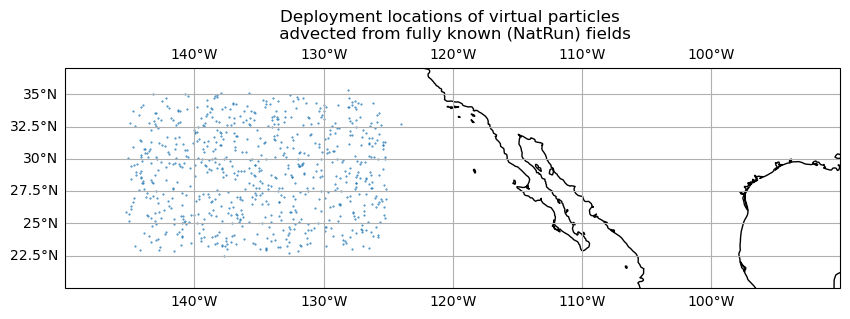

In [5]:
plt.figure(figsize = (10, 5))
projection = ccrs.PlateCarree(central_longitude=-50.0)
ax = plt.axes(projection = projection)
ax.coastlines()
ax.set_extent([-150, -90, 20, 37], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels = True)
gl.right_labels = False

ax = plt.scatter(np.array(data['NatRun_lon'])[::36], np.array(data['NatRun_lat'])[::36], transform = ccrs.PlateCarree(), s = 0.2)
plt.title('Deployment locations of virtual particles \n advected from fully known (NatRun) fields')


<h3> NatRun vs OSSE fields

In [10]:
import os
from os.path import splitext
import glob

# NatRun Curl files
lst_curl = "/home/daria/Documents/These/DATA/GLORYS_FIELDS/NAT_RUN_DRIFTERS/NatRun/DATED/TEST//CURL/CURL/GLOBC/"
#"/home/daria/Documents/These/DATA/GLORYS_FIELDS/NAT_RUN_DRIFTERS/Pacific/OSSE_PARCELS/NatRun_3nadirs/" + "CURL/GLOBC/"
os.chdir(lst_curl)
files_curl = np.array(glob.glob("*.nc"))
#print(splitext(splitext(files_curl[0])[0])[0].split('_')[-1])
files_curl = sorted(files_curl, key=lambda x: int(str(splitext(splitext(x)[0])[0].split('_')[-1])))
curl_NatRun = xr.open_dataset(lst_curl + files_curl[0])
data_curl_NatRun_vor = curl_NatRun.vor.values[0]
data_curl_NatRun_vor_new = np.concatenate((np.zeros((120, 4320)), data_curl_NatRun_vor))

#mypath = "/home/daria/Documents/These/DATA/GLORYS_FIELDS/NAT_RUN_DRIFTERS/NatRun_3nadir"
lst_curl = "/home/daria/Documents/These/DATA/GLORYS_FIELDS/NAT_RUN_DRIFTERS/NatRun_3nadir/CURL/GLOBC/"
#"/home/daria/Documents/These/DATA/GLORYS_FIELDS/NAT_RUN_DRIFTERS/Pacific/OSSE_PARCELS/NatRun_3nadirs/" + "CURL/GLOBC/"
os.chdir(lst_curl)
files_curl = np.array(glob.glob("*.nc"))
#print(splitext(splitext(files_curl[0])[0])[0].split('_')[-1])
files_curl = sorted(files_curl, key=lambda x: int(str(splitext(splitext(x)[0])[0].split('_')[-1])))
#sorted(files_curl, key=lambda x: int(str(splitext(splitext(x)[0])[0]).split('_')[0]))

data_curl = xr.open_dataset(files_curl[0])
data_curl_vor = data_curl.vor.values
data_curl_vor_new = np.concatenate((np.zeros((120, 4320)), data_curl_vor))

Text(0.5, 1.0, 'NatRun 3nadirs vs NatRun w/ corresponding trajs')

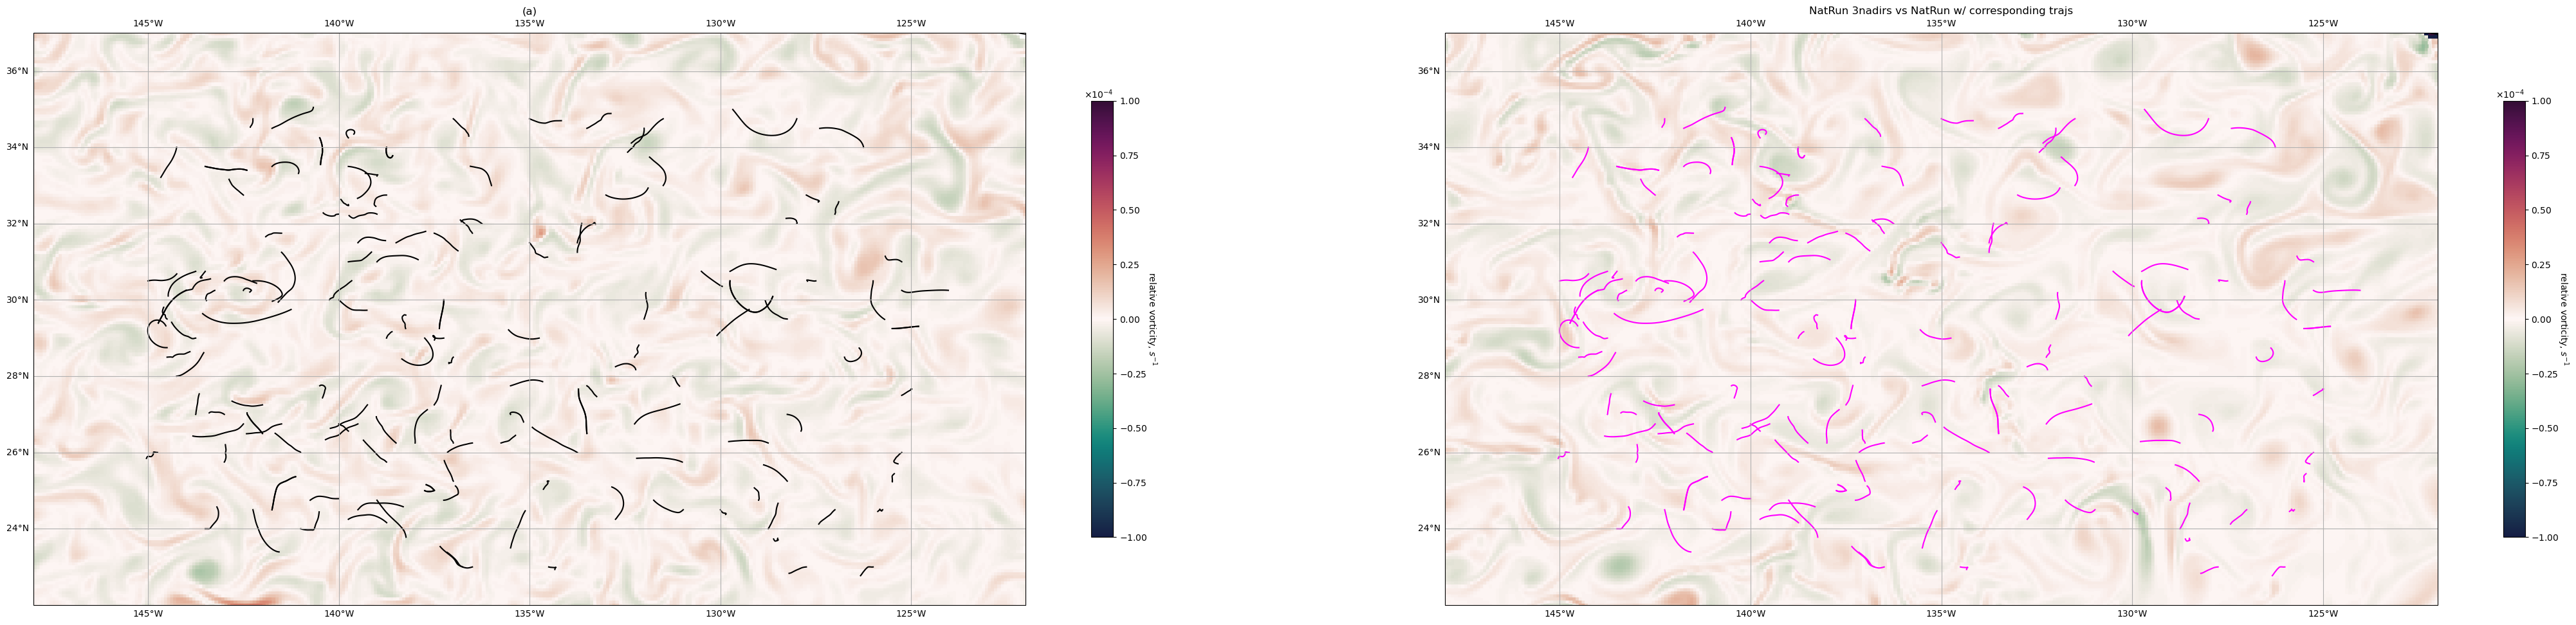

In [11]:
import cmocean
import matplotlib.gridspec as gridspec

inds = np.random.choice(np.arange(0, data.shape[0]//36, 1), 150)

widths = [1., 2., 1., 1., 1., 2., 1.]
heights = [1, 4.]
    
fig=plt.figure(constrained_layout=True, figsize = (40, 20))
gs = gridspec.GridSpec(1, 7, figure = fig, width_ratios=widths)
                        #  height_ratios=heights)

#fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-50.0)}, figsize=(20, 10))
ax1 = fig.add_subplot(gs[0, 0:3], projection = ccrs.PlateCarree(central_longitude=-50.0))
ax1.set_extent([-148, -122, 22, 37], crs=ccrs.PlateCarree())
ax1.coastlines()
gl = ax1.gridlines(draw_labels = True)
gl.right_labels = False
cm = ax1.imshow(data_curl_vor_new, transform=ccrs.PlateCarree(), origin = "lower", cmap = cmocean.cm.curl, vmin = -0.0001, vmax = 0.0001)
for i in range(inds.shape[0]):
    ax1.plot(data[data.filename == inds[i]].NatRun_3nadir_lon, data[data.filename == inds[i]].NatRun_3nadir_lat, c = 'black', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cm, fraction=0.022, pad=0.06)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.set_ylabel(r'relative vorticity, $s^{-1}$', rotation = 270, labelpad = 12)
ax1.set_title('(a)')


ax2 = fig.add_subplot(gs[0, 4:7], projection = ccrs.PlateCarree(central_longitude=-50.0))
ax2.set_extent([-148, -122, 22, 37], crs=ccrs.PlateCarree())
ax2.coastlines()
gl = ax2.gridlines(draw_labels = True)
gl.right_labels = False
cm = ax2.imshow(data_curl_NatRun_vor_new, transform=ccrs.PlateCarree(), origin = "lower", cmap = cmocean.cm.curl, vmin = -0.0001, vmax = 0.0001)
for i in range(inds.shape[0]):
    ax2.plot(data[data.filename == inds[i]].NatRun_3nadir_lon, data[data.filename == inds[i]].NatRun_3nadir_lat, c = 'magenta', transform=ccrs.PlateCarree())
cbar = plt.colorbar(cm, fraction=0.022, pad=0.06)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.set_ylabel(r'relative vorticity, $s^{-1}$', rotation = 270, labelpad = 12)
ax2.set_title('(b)')

plt.title('NatRun 3nadirs vs NatRun w/ corresponding trajs')


<h3> Apply pre-trained network to simulate trajectories in the Eastern North Pacific

In [23]:
orig_dir = os.getcwd()

GENERAL_PATH_DATA = '/home/daria/Documents/These/DATA/'

mypath_test = GENERAL_PATH_DATA + 'GLORYS_FIELDS/NAT_RUN_DRIFTERS/Pacific/NAT_RUN_3NADIRS/WINDOW_48/TEST/'
mypath_test_sst = mypath_test #GENERAL_PATH_DATA + '/SST_NATRUN/WINDOW_48/TEST/'
mypath_test_ssh = mypath_test_sst #GENERAL_PATH_DATA + '/SSH_NAT_RUN/WINDOW_48/TEST/'

os.chdir(mypath_test)
files = np.array(glob.glob('*.nc'))
os.chdir(mypath_test_sst)
files_sst = np.array(glob.glob('*.nc'))
os.chdir(mypath_test_ssh)
files_ssh = np.array(glob.glob('*.nc'))
#print(files_ssh)
onlyfiles_test = sorted(files, key=lambda x: int(str(splitext(splitext(x)[0])[0]).split('_')[0]))
onlyfiles_test_sst =  sorted(files_sst, key=lambda x: int(str(splitext(splitext(x)[0])[0]).split('_')[0]))
onlyfiles_test_ssh =  sorted(files_ssh, key=lambda x: int(str(splitext(splitext(x)[0])[0]).split('_')[0]))

os.chdir(orig_dir)


In [24]:
train_index_0 = 7
train_index_1 = 8
batch_size = 32
days = 9

In [25]:
def get_relative_init_pos(position, lon_lats):  # lon_lats (10417, 14, 14, 2).reshape -> (10417, 14*14, 2)
        #rint(position)
        norms_lon = np.stack([(p[0] - lon_lats[0,:,:])**2 for p in position]) # (N, 14, 14)
        norms_lat = np.stack([(p[1] - lon_lats[1,:,:])**2 for p in position])
        #rint(norms_lon.shape)
        norms_distance = np.stack([np.sqrt(n_lon_lat[0] + n_lon_lat[1]) for n_lon_lat in zip(norms_lon, norms_lat)])    # (14, 14)
        norms_distance = -norms_distance
        norms_distance += np.abs(np.min(norms_distance, axis = (1, 2), keepdims = True))#reshape(norms_distance.shape)
        norms_distance /= np.max(norms_distance, axis = (1, 2), keepdims = True)#.reshape(norms_distance.shape)

        return norms_distance

def extract_map_init_cond_position(data, N_uv, path, files, train_index_0):
        init_cond_position = np.zeros((data.shape[0], 36, N_uv, N_uv))
        #for i, traj in enumerate(data):
        filename = data[:,0, 9]
        filenames = np.array([glob.glob(path + files[int(f)]) for f in filename])[:,0]
        print(np.array(filenames).shape)
        for i, f in enumerate(filenames):
            cond_uv = xr.open_dataset(f)
            #rint(cond_uv)
            #rint('Traj ' + str(i + 1) + ' processed')
            #for step in range(36):
            position = data[i,:, train_index_0:train_index_0 + 2]
                #cond_uv = xr.open_dataset(path + files[filename])
            #ond_uv = xr.open_mfdataset(filenames)

            lats = np.array([[cond_uv.latitude]])
            lons = np.array([[cond_uv.longitude]])

            #lats = np.array([[coordinates[0, 1]]]) #np.array([[cond_uv.latitude]])
            #lons = np.array([[coordinates[0, 0]]]) #np.array([[cond_uv.longitude]])

            mesh = np.array(np.meshgrid(lons, lats, indexing = 'ij'))

            matrix_distances_from_init_pos = get_relative_init_pos(position, mesh)
            init_cond_position[int(i), :, :, :] = matrix_distances_from_init_pos
                #int(f), :, :, :] = matrix_distances_from_init_pos
            #rint('Processed')
        return init_cond_position


In [26]:
data_test_1day = np.loadtxt(GENERAL_PATH_DATA + '/TEST_processed_DATASET_Pacific.txt')
data_test_1day = data_test_1day.reshape(int(data_test_1day.shape[0]/36), 36, 14)

In [27]:
init_cond_positions_test = extract_map_init_cond_position(data_test_1day, 48, mypath_test, onlyfiles_test, train_index_0)
init_cond_positions_test = torch.Tensor(init_cond_positions_test)

(700,)


In [28]:
class ToTensor(object):
        """Convert ndarrays in sample to Tensors."""
        def __call__(self, sample):
            return torch.Tensor(sample)#cuda()# torch.Tensor(sampleV).cuda    

def collate_fn(batch):
        return tuple(zip(*batch))


class CommonDataSet(torch.utils.data.Dataset):
    def __init__(self, data, path, files, init_position, files_SST, path_SST, files_SSH, path_SSH, transform=None):
        self.data = data
        #elf.condition = condition
        self.init_position = init_position
        self.files_sst = files_SST
        self.path_sst = path_SST
        self.transform = transform
        self.files_ssh = files_SSH
        self.path_ssh = path_SSH
        self.path = path
        self.files = files
        #self.all_init_pos = all_init_pos

    def __len__(self): return self.data.shape[0]
    
    def __getitem__(self, traj_num): # date = YYYY-MM-
        sampleDATA = self.data[traj_num]
        #print(sampleDATA[0, :4])
        #print(sampleDATA.shape)
        filename = sampleDATA[0, 9]
        #print(filename)
        sampleINIT_POSITION = self.init_position[traj_num]
        #all_sampleINIT_MAPS = self.all_init_pos[traj_num]
        #print(self.init_position.shape, sampleINIT_POSITION.shape
        #print(str(self.path) + str(self.files[int(filename)]))
        dataset = xr.open_dataset(str(self.path) + str(self.files[int(filename)]))


        #print(dataset)

        sampleDATASET_U = dataset.vozocrtxT.values[:9]
        sampleDATASET_V = dataset.vomecrtyT.values[:9]


        #dataset_sst = xr.open_dataset(str(self.path_sst) + str(self.files_sst[int(filename)]))
        #dataset_ssh = xr.open_dataset(str(self.path_ssh) + str(self.files_ssh[int(filename)]))

        #sampleDATASET_SST = np.array(dataset_sst.votemper.values[:9, 0])
        #sampleDATASET_SSH = np.array(dataset_ssh.sossheig.values[:9])

        coordinates = np.stack((dataset.longitude.values, dataset.latitude.values), 0)
        #print('HEYIOODKCFKFKKF')
        #print(coordinates)

        dataset.close()
        
        if self.transform:
            sampleDATA = self.transform(sampleDATA)
            sampleINIT_POSITION = self.transform(sampleINIT_POSITION)
            #all_sampleINIT_MAPS = self.transform(all_sampleINIT_MAPS)
            sampleDATASET_U = self.transform(sampleDATASET_U)
            sampleDATASET_V = self.transform(sampleDATASET_V)
            #ampleDATASET_U = (sampleDATASET_U - torch.mean(sampleDATASET_U)) / torch.std(sampleDATASET_U)
            #sampleDATASET_V = (sampleDATASET_V - torch.mean(sampleDATASET_V))/torch.std(sampleDATASET_V)

            #sampleDATASET_SST = self.transform(sampleDATASET_SST)
            #sampleDATASET_SSH = self.transform(sampleDATASET_SSH)

            coordinates = self.transform(coordinates)

        idc1_2U = torch.where(torch.isnan(sampleDATASET_U))
        idc1_2V = torch.where(torch.isnan(sampleDATASET_V))
        zero_Tensor = self.transform(torch.Tensor([0.]))

        sampleDATASET_U[idc1_2U] = zero_Tensor
        sampleDATASET_V[idc1_2V] = zero_Tensor

        #f(len(idc1_2V[0]) > 0.):
        #    print('Nan UV after processing')
        #    print(torch.where(torch.isnan(sampleDATASET_U)))

        idc1_2U = torch.where(torch.abs(sampleDATASET_U) > 1e2)
        idc1_2V = torch.where(torch.abs(sampleDATASET_V) > 1e2)

        sampleDATASET_U[idc1_2U] = zero_Tensor
        sampleDATASET_V[idc1_2V] = zero_Tensor
        
        uv = torch.stack((sampleDATASET_U, sampleDATASET_V), dim = 1)
        #rint(uv)
        #print('UV shape')
        #print(uv.shape)

        return sampleDATA, uv, sampleINIT_POSITION, coordinates # 2 - u et v,



In [29]:
datasetLIST_test = CommonDataSet(data_test_1day,  mypath_test, onlyfiles_test, init_cond_positions_test, onlyfiles_test_sst, mypath_test_sst, onlyfiles_test_ssh, mypath_test_ssh, transform =  transforms.Compose([ToTensor()]))
validation_commonDataSet_valid_loader = torch.utils.data.DataLoader(datasetLIST_test, batch_size= batch_size, shuffle=False, drop_last = True, num_workers = 8)#, collate_fn = collate_fn)
N_var_cond = 2

<h4> The DriftNet model

In [30]:
class ConvLSTMCell(nn.Module):
    
        def __init__(self, input_dim, hidden_dim, kernel_size, bias):
            """
            Initialize ConvLSTM cell.
        
            Parameters
            ----------
            input_dim: int
                Number of channels of input tensor.
            hidden_dim: int
                Number of channels of hidden state.
            kernel_size: (int, int)
                Size of the convolutional kernel.
            bias: bool
                Whether or not to add the bias.
            """
        
            super(ConvLSTMCell, self).__init__()
        
            self.input_dim = input_dim
            self.hidden_dim = hidden_dim
        
            self.kernel_size = kernel_size
            self.padding = kernel_size[0] // 2, kernel_size[1] // 2
            self.bias = bias
        
            self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
        
        def forward(self, input_tensor, cur_state):
            h_cur, c_cur = cur_state
        
            combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
            combined_conv = self.conv(combined)
            cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
            i = torch.sigmoid(cc_i)
            f = torch.sigmoid(cc_f)
            o = torch.sigmoid(cc_o)
            g = torch.tanh(cc_g)
        
            c_next = f * c_cur + i * g
            h_next = o * torch.tanh(c_next)
        
            return h_next, c_next
    
        def init_hidden(self, batch_size, image_size):
            height, width = image_size
            return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
            torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    
        """
    
        Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    
        Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
        Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                each element of the list is a tuple (h, c) for hidden state and memory
        Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
        """
    
        def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
             batch_first=False, bias=True, return_all_layers=False):
            super(ConvLSTM, self).__init__()
        
            self._check_kernel_size_consistency(kernel_size)
        
            # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
            kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
            hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
            if not len(kernel_size) == len(hidden_dim) == num_layers:
                raise ValueError('Inconsistent list length.')
        
            self.input_dim = input_dim
            self.hidden_dim = hidden_dim
            self.kernel_size = kernel_size
            self.num_layers = num_layers
            self.batch_first = batch_first
            self.bias = bias
            self.return_all_layers = return_all_layers
        
            cell_list = []
            for i in range(0, self.num_layers):
                cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]
        
                cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))
        
            self.cell_list = nn.ModuleList(cell_list)
        
    
        def forward(self, input_tensor, hidden_state=None):
            """
        
            Parameters
            ----------
            input_tensor: todo
                5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
            hidden_state: todo
                None. todo implement stateful
        
            Returns
            -------
            last_state_list, layer_output
            """
            if not self.batch_first:
                # (t, b, c, h, w) -> (b, t, c, h, w)
                input_tensor = input_tensor.permute(1, 0, 2, 3, 4)
        
            b, _, _, h, w = input_tensor.size()
        
            # Implement stateful ConvLSTM
            if hidden_state is not None:
                raise NotImplementedError()
            else:
                # Since the init is done in forward. Can send image size here
                hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))
        
            layer_output_list = []
            last_state_list = []
        
            seq_len = input_tensor.size(1)
            cur_layer_input = input_tensor
        
            for layer_idx in range(self.num_layers):
        
                h, c = hidden_state[layer_idx]
                output_inner = []
                for t in range(seq_len):
                    h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                     cur_state=[h, c])
                    output_inner.append(h)
        
                layer_output = torch.stack(output_inner, dim=1)
                cur_layer_input = layer_output
        
                layer_output_list.append(layer_output)
                last_state_list.append([h, c])
            if not self.return_all_layers:
                layer_output_list = layer_output_list[-1:]
                last_state_list = last_state_list[-1:]
    
            return layer_output_list, last_state_list
    
        def _init_hidden(self, batch_size, image_size):
            init_states = []
            for i in range(self.num_layers):
                init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
            return init_states
    
        @staticmethod
        def _check_kernel_size_consistency(kernel_size):
            if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
                raise ValueError('`kernel_size` must be tuple or list of tuples')
        
        @staticmethod
        def _extend_for_multilayer(param, num_layers):
            if not isinstance(param, list):
                param = [param] * num_layers
            return param

In [31]:
class DriftNetDATARMOR(nn.Module):
        def __init__(self):
            super(DriftNetDATARMOR, self).__init__()

            self.first_cond_input = (N_var_cond + 1) * 9
            #self.N_uv = N_uv
            self.days = days
            self.first_conv_kernel_spatial = 3 #5 # 8 avant   ¸ THE LAST MODIF IS HERE 2 -> 1 (1 found previously as the best) , 3 before for spatial kernel
            self.first_conv_kernel_temporal = 5  # 5 before for temporal kernel
            self.hidden_state = 64
            self.first_cond_output = self.hidden_state
            self.batch_size = batch_size

            self.conv_layer1 = self._conv_layer_set(self.first_cond_input, self.first_cond_output, self.first_conv_kernel_temporal, self.first_conv_kernel_spatial, self.first_conv_kernel_spatial)  # avant -> 4, 4

            self.CONV_LSTM_layer = ConvLSTM(9, 48, (7, 7), 1, batch_first=True, bias=True, return_all_layers=False)

            self.cnn = nn.Sequential(
                nn.Conv2d(self.hidden_state * 48, 48, kernel_size = (2, 2), stride = 1, padding = 'same', padding_mode = 'reflect', bias = False), # 2, 2 before
            )


        def _conv_layer_set(self, in_c, out_c, k1, k2,k3):
            conv_layer = nn.Sequential(
            nn.Conv2d(in_c, out_c * 9, kernel_size=(k2, k3), padding = 'same', padding_mode = 'reflect', bias = False),
            nn.LeakyReLU(True),
            )
            return conv_layer

        def pdf(self,out):
            out = self.cnn(out)

            return out   #.transpose(1, 2)   # 64, 32, 64

        def temporal_lstm_loop(self, out, previous):

            out_temporal, hidden = self.CONV_LSTM_layer(out, previous)

            return out_temporal, hidden
        
        def forward(self, cond_input):

            #print('INP shape')
            #print(cond_input.shape)

            out = self.conv_layer1(cond_input.view(cond_input.size()[0], -1, *cond_input.size()[-2:]))

            out_temporal, hidden = self.temporal_lstm_loop(out.view(cond_input.size()[0], self.hidden_state, self.days, *cond_input.size()[-2:]), None)

            out = self.pdf(out_temporal[0].view(cond_input.size()[0], -1, *cond_input.size()[-2:]))
            #out = nn.Upsample((out.size()[-2] * 2, out.size()[-1]*2))(out)

            return out.unsqueeze(1) #out[:,:,1:], out_CNN #.a    transpose(1, 2) 



In [32]:
def gridPDF_to_gridLatLon(out, N_uv, coordinates):
        out_final = torch.zeros((batch_size, 2, 36))
        #for j in range(0, batch_size):
        for time_step in range(9 * 4):
            dx = 1/12
            #(torch.ceil(torch.max(coordinates[:,0], -1)[0]) - torch.floor(torch.min(coordinates[:,0], -1)[0]))/N_uv
            # Size :  batch_size
            dy = 1/12
            #(torch.ceil(torch.max(coordinates[:,1], -1)[0]) - torch.floor(torch.min(coordinates[:,1], -1)[0]))/N_uv
                      
            x = [torch.arange(torch.min(x[0], -1)[0], torch.min(x[0], -1)[0] + N_uv * dx, dx)[:N_uv] for x in coordinates]
            y = [torch.arange(torch.min(x[1], -1)[0], torch.min(x[1], -1)[0] + N_uv * dy, dy)[:N_uv] for x in coordinates]
            grid_XXgridYY = [torch.meshgrid(xx, yy, indexing='ij') for xx, yy in zip(x, y)]
            x = torch.cat([torch.sum(torch.mul(out_individual[:,time_step], x[0]), (1,2)) for x, out_individual in zip(grid_XXgridYY, out)]).unsqueeze(1)
            y = torch.cat([torch.sum(torch.mul(out_individual[:,time_step], x[1]), (1,2)) for x, out_individual in zip(grid_XXgridYY, out)]).unsqueeze(1)
            out_final[:,:,time_step] = torch.cat([x,y], 1) #for xx, yy in zip(x, y)])
            
        return out_final[:,:,1:]
    
def torch_LagrLiuIndex(trajS, trajP):
    
       
        sepDistancesPS = torch.sqrt( (trajS[:,0, :] - trajP[:,0,:])** 2 + (trajS[:,1,:] - trajP[:,1,:])** 2 )
        SumSepDist = torch.sum(sepDistancesPS, axis = 1)
        distancesP = torch.sqrt(torch.diff(trajP[:,0,:])**2 + torch.diff(trajP[:,1,:])**2)
        distancesP = torch.cat((torch.zeros((trajP.shape[0],1)), distancesP), 1)  # add 0 at first position
        distancesS = torch.sqrt(torch.diff(trajS[:,0,:])**2 + torch.diff(trajS[:,1,:])**2)
        distancesS = torch.cat((torch.zeros((trajS.shape[0],1)), distancesS), 1)
        
        cumsumP = torch.sum(torch.cumsum(distancesP, axis = 1), axis = 1)
        cumsumS = torch.sum(torch.cumsum(distancesS, axis = 1), axis = 1)
        #print(cumsumP)
    
        liuIndex_P_S = SumSepDist / cumsumP
        #print(liuIndex_P_S)
    
        #print(torch.mean(liuIndex_P_S))
        
        return torch.mean(liuIndex_P_S)

In [33]:
model = torch.load("/home/daria/Documents/These/PAPER_DriftNet/MODELS_NATRUN_PACIFIC/model_EPOCH46.pt", map_location = "cpu")

In [34]:
DriftNet_model = DriftNetDATARMOR()
DriftNet_model.load_state_dict(model['G_model_state_dict'])

<All keys matched successfully>

In [35]:
class PL_DRIFT_NET(pl.LightningModule):
        def __init__(self):
            super().__init__()
    
            self.DriftNet_model = DriftNetDATARMOR()
            checkpoint = torch.load("/home/daria/Documents/These/PAPER_DriftNet/MODELS_NATRUN_PACIFIC/model_EPOCH46.pt", map_location = "cpu")
            #torch.load('/DATASET/data_GS_OSSE/EXPERIMENTS/RESOLUTION_1_6/TARGET_NatRun/INPUT_NatRun/BEST_MODELS_PACIFIC/model_EPOCH401.pt')
            self.DriftNet_model.load_state_dict(checkpoint['G_model_state_dict'])
           
            self.MSE = nn.MSELoss()   
            
            self.Distance = []
            self.Liu = []       
            #self.automatic_optimization = False
            
            
        def forward(self, input_cond):
            out = self.DriftNet_model(input_cond)       
               
            return out
            
        def compute_loss(self, batch):
            N_uv = 48
            Nb_px_resolution = 1
            # sampleDATA, uv, sampleINIT_POSITION, coordinates
            init_position_all = batch[2]
            #position_maps = batch[2]
            real_data_all = batch[0]
            condition_all = batch[1]
            coordinates = batch[-1]
        
            init_position_all_softmax = init_position_all
            #print('Mean SST value')
            #print(condition_all[:,:,-1].mean())
            #print('Is nan')
            #print(torch.where(torch.isnan(condition_all[:,:,-1])))
            #m = plt.imshow(condition_all.clone().cpu()[0, 0, -1])
            #plt.colorbar(im)
            #plt.show()
        
            cond_input = torch.cat((condition_all.transpose(1, 2), torch.cat((init_position_all_softmax.transpose(1, 2)[:,:,0].squeeze().unsqueeze(1).unsqueeze(2), torch.ones((batch_size, 1, 8, N_uv, N_uv))), 2)), dim = 1)
            if(Nb_px_resolution > 1):
                cond_input = torch.nn.functional.interpolate(cond_input, (9, N_uv//Nb_px_resolution, N_uv//Nb_px_resolution), mode = "trilinear")
                #ond_input = nn.AvgPool3d((1, Nb_px_resolution, Nb_px_resolution))(cond_input)
        
            generated_all = self(cond_input)
            if(Nb_px_resolution > 1):
                generated_all = torch.nn.functional.interpolate(generated_all, (generated_all.shape[-3] , N_uv, N_uv), mode = "trilinear")
            generated_all_softmax = nn.Softmax(3)(generated_all.view(*generated_all.size()[:3], -1)).view_as(generated_all)[:,:,:36]
            real_all_softmax = nn.Softmax(3)(init_position_all.view(*init_position_all.size()[:3], -1)).view_as(init_position_all)
            
            generated = gridPDF_to_gridLatLon(generated_all_softmax, N_uv, coordinates)   # 64, 2, 35
            
            tr_REAL = real_data_all[:,:,train_index_0 : train_index_0 + 2]
            
            #int(tr_REAL.shape, generated.shape)
            generated_complete = torch.cat((tr_REAL[:,0].unsqueeze(2), generated), 2)
            
            Liu = torch_LagrLiuIndex(generated_complete, tr_REAL.transpose(1, 2))
            
            loss = 0.8 * self.MSE(generated_complete.transpose(1, 2).squeeze(), tr_REAL.squeeze()) + 0.2 * Liu #+ w_maps * self.MSE(generated_all_softmax.squeeze(), real_all_softmax.squeeze())
           
            return loss, generated_complete, generated
            
        def training_step(self, batch, batch_idx): ## TODO 1
        
            loss, output, gen_all = self.compute_loss(batch)
            Distance = self.compute_Distance(batch, output)[0]
        
            self.log('train_loss', loss) ## TODO 3
            self.log('train_distance', Distance)

            #sch = self.lr_schedulers()
            #sch.step()
            
            
            return loss
        
        def on_train_epoch_end(self):
            return
    
        def compute_Distance(self, batch, output):
            data = batch[0][:,:,train_index_0:train_index_0+2]
            simulated_data = output
            scale_factor_coord = 95.
            #print(data.shape, output.shape)  # 36, 2 and 2, 36
        
            Distance=  torch.sqrt( torch.sum( ( data[:,-1,:] - simulated_data[:,:,-1] )**2 , dim = -1) ) # * scale_factor_coord
        
            return torch.mean(Distance, dim = 0) * scale_factor_coord, torch.std(Distance, dim = 0) * scale_factor_coord # in km        
        
      
        # compute and stock the loss        
        def validation_step(self, batch, batch_idx): ## TODO 1
            init_position_all = batch[-2].squeeze(0).unsqueeze(2)
            position_maps = batch[-1]
            real_data_all = batch[0]
            condition_all = batch[1][:,:-1,:,:]
        
            positions_all_maps_softmax = nn.Softmax(3)(position_maps.view(*position_maps.size()[:3], -1)).view_as(position_maps)
        
            real_data = batch[0]
            loss,output, generated_all = self.compute_loss(batch)
            Distance = self.compute_Distance(batch, output)[0]
            self.val_Distance.append(Distance)
        
            self.log('val_loss', loss) ## TODO 3
            self.log('val_distance', Distance)
        
            self.validation_step_outputs.append(output.transpose(1, 2))
            self.validation_step_real_data.append(real_data_all)
        
            return loss
            
        def on_validation_epoch_start(self):
            self.validation_step_outputs = []
            self.validation_step_real_data = []
            self.val_Distance = []
            return
        
        
        def on_validation_epoch_end(self):  
            dist = torch.stack(self.val_Distance).view(-1)
            print('Mean DIstance : ' + str(torch.mean(dist)))

            return    
          
        def configure_optimizers(self): ## TODO 1
            opt = torch.optim.Adam(self.parameters(),lr = lr, betas=(0.5,0.999))#eps=1e-08,weight_decay=0) 
            #sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=15 + 55 + 25 + 25) # New
            #scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, total_steps=self.trainer.estimated_stepping_batches)
        
            return opt #[opt], [scheduler]
            '''{
                "optimizer": opt,
                
                "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "step", # step means "batch" here, default: epoch   # New!
                "frequency": 1, # default
                
                },
                
                }
            '''
            
        def on_test_epoch_start(self): ## TODO 5
            self.validation_step_outputs = []
            self.validation_step_real_data = []
        
        
        
        def test_step(self, batch, batch_idx): ## TODO 
       
            init_position_all = batch[2]
            #position_maps = batch[2]
            real_data_all = batch[0]
            condition_all = batch[1]
            coordinates = batch[-1]
            tr_REAL = real_data_all[:,:,train_index_0 : train_index_0 + 2]
            #r_REAL = tr_REAL.to(dev)

            loss,output, generated_all = self.compute_loss(batch)
        
            self.validation_step_outputs.append(output.transpose(1, 2))
            self.validation_step_real_data.append(real_data_all)

            self.Distance.append( self.compute_Distance(batch, output)[0])
            #rint(real_data_all[:,:,train_index_0 : train_index_0 + 2].transpose(1, 2).shape, output.shape)
            self.Liu.append(torch_LagrLiuIndex(real_data_all[:,:,train_index_0 : train_index_0 + 2].transpose(1, 2), output))

                #print('Distance ' + str(Distance[0]))
                #print('Liu ' + str(Liu))
        
            return output, real_data_all
    
        def on_test_epoch_end(self): ## TODO 5
           
            print('Mean Distance ' + str(torch.mean(torch.stack(self.Distance).view(-1))))
            print('Mean Liu ' + str(torch.mean(torch.stack(self.Liu).view(-1))))
        
            all_preds = torch.stack(self.validation_step_outputs)
            all_real = torch.stack(self.validation_step_real_data)
            all_real = all_real.view(-1, *all_real.size()[3:]).detach().cpu().numpy()
            all_preds = all_preds.view(-1, *all_preds.size()[2:])#transpose(1, 2)
            all_preds = all_preds.reshape(all_preds.shape[0]*all_preds.shape[1], all_preds.shape[-1]).detach().cpu().numpy()
            #print(all_preds.shape, all_real.shape)
            #print(all_real[:,9])
            #print(torch.mean(torch.stack(self.Distance)), torch.mean(torch.stack(self.Liu)))
            #print(torch.stack(self.validation_step_real_data).view(-1, 36, 14).transpose(1, 2).shape, torch.stack(self.validation_step_outputs).view(-1, 36, 2).transpose(1, 2).shape)
            '''
            plot(torch.stack(self.validation_step_real_data).view(-1, 36, 14).cpu().numpy()[:,:,train_index_0:train_index_0 + 2], torch.stack(self.validation_step_outputs).view(-1, 36, 2).cpu().numpy(), torch.stack(self.validation_step_real_data).view(-1, 36, 14).cpu().numpy()[:,:,parcels_train_index_0:parcels_train_index_0 + 2], batch_size, 0 + 0, 'TEST', parcels = False)
            plt.show()
            plt.close()
            '''
        
            data = pd.DataFrame()
            data['NatRun_lon_simulated'] = all_preds[:,0]
            data['NatRun_lat_simulated'] = all_preds[:,1]
        
            data['NatRun_3nadirs_lon'] = all_real[:,2]
            data['NatRun_3nadirs_lat'] = all_real[:,3]
        
            #data['NatRun_lon'] = all_real[:,0]
            #data['NatRun_lat'] = all_real[:,1]
            data['NatRun_lon'] = all_real[:,train_index_0]
            data['NatRun_lat'] = all_real[:,train_index_0 + 1]
        
            #data['real_dlon_parcels'] = all_real[:,10]
            #data['real_dlat_parcels'] = all_real[:,11]
        
            data['filenames'] = all_real[:,9]
        
            print('Final data')
            print(data)
        
            #df[['Real_NatRun_3nadirs_dlon', 'Real_NatRun_3nadirs_dlat']] = all_real[:, 2:4]
            #df[['Real_NatRun_dlon', 'Real_NatRun_dlat']] = all_real[:, 0:2]
            #df[['Real_NatRun_3nadirs_lon', 'Real_NatRun_3nadirs_lat']] = all_real[:, 10:12]
            #df[['Real_NatRun_lon', 'Real_NatRun_lat']] = all_real[:, 7:9]
            #df[['filename']] = np.expand_dims(all_real[:, 9], -1)
        
            #df[['Sim_NatRun_3nadirs_dlon', 'Sim_NatRun_3nadirs_dlat']] = all_preds[:, 0:2]
        
            data.to_csv("/home/daria/Documents/These/PAPER_DriftNet/" + 'generated_trajectories.csv')
         
            #final_data.to_csv(self.path + '/v' + version +  '_GS_out_validation.csv')
    
        

In [36]:
model = PL_DRIFT_NET()

In [37]:
trainer = pl.Trainer(
            accelerator='cpu',
            devices=1, 
        )
        
trainer.test(model, dataloaders = validation_commonDataSet_valid_loader)#, ckpt_path="best")
        

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daria/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Testing: |                                                | 0/? [00:00<?, ?it/s]

Mean Distance tensor(41.5947)
Mean Liu tensor(1.2180)
Final data
       NatRun_lon_simulated  NatRun_lat_simulated  NatRun_3nadirs_lon  \
0               -143.000000             23.750000             0.00000   
1               -142.958908             23.791811             0.07050   
2               -142.907837             23.827156             0.14664   
3               -142.860733             23.845343             0.22620   
4               -142.809540             23.877588             0.30856   
...                     ...                   ...                 ...   
24187           -138.555756             29.040199             0.11542   
24188           -138.539795             29.043484             0.12146   
24189           -138.527405             29.044918             0.12732   
24190           -138.508255             29.045067             0.13309   
24191           -138.495148             29.043451             0.13876   

       NatRun_3nadirs_lat  NatRun_lon  NatRun_lat  filenam

[{}]

In [38]:
data_simulated = pd.read_csv("/home/daria/Documents/These/PAPER_DriftNet/" + 'generated_trajectories.csv')
data_simulated

,Unnamed: 0,NatRun_lon_simulated,NatRun_lat_simulated,NatRun_3nadirs_lon,NatRun_3nadirs_lat,NatRun_lon,NatRun_lat,filenames
0,0,-143.00000,23.750000,0.00000,0.000000,-143.00000,23.750000,0.0
1,1,-142.95891,23.791811,0.07050,0.041424,-142.94972,23.796007,0.0
2,2,-142.90784,23.827156,0.14664,0.075947,-142.89407,23.841460,0.0
3,3,-142.86073,23.845343,0.22620,0.104317,-142.83319,23.886003,0.0
4,4,-142.80954,23.877588,0.30856,0.124666,-142.76581,23.929937,0.0
...,...,...,...,...,...,...,...,...
24187,24187,-138.55576,29.040200,0.11542,0.152460,-138.53800,29.038988,671.0
24188,24188,-138.53980,29.043484,0.12146,0.156164,-138.53140,29.025633,671.0
24189,24189,-138.52740,29.044918,0.12732,0.159315,-138.52563,29.011630,671.0
24190,24190,-138.50826,29.045067,0.13309,0.162308,-138.52039,28.997147,671.0


<h3> Metrics

In [82]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]


############################################# Autocorrelation for velocity  #######################"
#u /= 10417
def autocor_plot(train, exp, drifters):
    #t = np.arange(0, 9, 0.25)
    N_traj = train.shape[0] // 36
    traj_sim, traj_real, traj_parcels, ts = \
    np.zeros((N_traj, 2, 36)), np.zeros((N_traj, 2, 36)),  np.zeros((N_traj, 2, 36)), np.zeros((N_traj, 2, 36))
    filenames = np.zeros((N_traj, 36))
    # CHANGE 2 to 4 !!! if new version of gen30 !!!
    R_u_real, R_v_real = np.zeros((N_traj, 36)), np.zeros((N_traj, 36))
    R_u_sim, R_v_sim = np.zeros((N_traj, 36)), np.zeros((N_traj, 36))
    R_u_parc, R_v_parc = np.zeros((N_traj, 36)), np.zeros((N_traj, 36))
    #names = train.name.unique()
    print(traj_sim.shape)
    for i in range(0, N_traj):        
        #traj_sim[i] = np.array([train.loc[i * 36 : i*36 + 35, 'simul_dlon_batch_'], \
        #                 train.loc[i * 36 : i*36 + 35, 'simul_dlat_batch_']])
        
        
        # FOR DRIFTERS
        if (drifters):
            traj_sim[i] = np.array([train.loc[i * 36 : i*36 + 35, 'simul_dlon_batch_'], \
                                    train.loc[i * 36 : i*36 + 35, 'simul_dlat_batch_'] ])
        
        # FOR OSSE
        else:   
            traj_sim[i] = np.array([train.loc[i * 36 : i*36 + 35, 'NatRun_lon_simulated'] ,\
                                    train.loc[i * 36 : i*36 + 35, 'NatRun_lat_simulated'] ])

        ts[i][0][1:] = np.diff(traj_sim[i][0][:])
        ts[i][0][1:] = ts[i][0][1:] - np.mean(ts[i][0][1:])
        ts[i][0][:][0] = 0.
        ts[i][1][1:] = np.diff(traj_sim[i][1][:])
        ts[i][1][1:] = ts[i][1][1:] - np.mean(ts[i][1][1:])
        ts[i][1][:][0] = 0.
        #traj_sim[i][0][:] -= np.mean(traj_sim[i][0][:])
        #traj_sim[i][1][:] -= np.mean(traj_sim[i][1][:])
        R_u_sim[i] = autocorr(ts[i][0][:]) / np.mean((ts[i][0][:])**2) / 36
        #print(R_u_sim)
        R_v_sim[i] = autocorr(ts[i][1][:]) / np.mean((ts[i][1][:] )**2) / 36
        
        
        if(drifters):
            traj_real[i] = np.array([train.loc[i * 36 : i*36 + 35, 'real_dlon_batch_'] , train.loc[i * 36 : i*36 + 35, 'real_dlat_batch_']])
        else:
            traj_real[i] = np.array([train.loc[i * 36 : i*36 + 35, 'NatRun_lon'],  \
                                     train.loc[i * 36 : i*36 + 35, 'NatRun_lat']])
                                     #+ train.loc[i * 36 , 'simul_dlon_batch_'], train.loc[i * 36 : i*36 + 35, 'real_dlat_batch_'] + train.loc[i * 36 , 'simul_dlat_batch_']])

        filenames[i] = np.array(train.loc[i * 36 : i*36 + 35, 'filenames'])
       
        
        ts[i][0][1:] = np.diff(traj_real[i][0][:])
        ts[i][0][1:] = ts[i][0][1:] - np.mean(ts[i][0][1:])
        ts[i][0][:][0] = 0.
        ts[i][1][1:] = np.diff(traj_real[i][1][:])
        ts[i][1][1:] = ts[i][1][1:] - np.mean(ts[i][1][1:])
        ts[i][1][:][0] = 0.
        
        R_u_real[i] = autocorr(ts[i][0][:]) / np.mean((ts[i][0][:])**2) / 36
        R_v_real[i] = autocorr(ts[i][1][:]) / np.mean((ts[i][1][:] )**2) / 36
        
        # FOR DRIFTErS IN PACIFIC ONLY !!!
        if(drifters):
            traj_parcels[i] = np.array([train.loc[i * 36 : i*36 + 35, 'real_dlon_parcels'] + train.loc[i * 36 , 'simul_dlon_batch_'], \
                                        train.loc[i * 36 : i*36 + 35, 'real_dlat_parcels'] + train.loc[i * 36 , 'simul_dlat_batch_']])
        
        # FOR OSSE FRAMEWORK !!!
        else:   
            traj_parcels[i] = np.array([train.loc[i * 36 : i*36 + 35, 'NatRun_3nadirs_lon'] + train.loc[i * 36 , 'NatRun_lon'], \
                                        train.loc[i * 36 : i*36 + 35, 'NatRun_3nadirs_lat'] + train.loc[i * 36 , 'NatRun_lat']])
        
        ts[i][0][1:] = np.diff(traj_parcels[i][0][:])
        ts[i][0][1:] = ts[i][0][1:] - np.mean(ts[i][0][1:])
        ts[i][0][:][0] = 0.
        ts[i][1][1:] = np.diff(traj_parcels[i][1][:])
        ts[i][1][1:] = ts[i][1][1:] - np.mean(ts[i][1][1:])
        ts[i][1][:][0] = 0.
       
        R_u_parc[i] = autocorr(ts[i][0][:]) / np.mean((ts[i][0][:])**2) / 36
        R_v_parc[i] = autocorr(ts[i][1][:]) / np.mean((ts[i][1][:] )**2) / 36

    
    R_u_real = np.delete(R_u_real, np.where(np.isnan(R_u_real) == True)[0], axis = 0)
    
    R_v_real = np.delete(R_v_real, np.where(np.isnan(R_v_real) == True)[0], axis = 0)
    R_u_sim = np.delete(R_u_sim, np.where(np.isnan(R_u_sim) == True)[0], axis = 0)
    R_v_sim = np.delete(R_v_sim, np.where(np.isnan(R_v_sim) == True)[0], axis = 0)
    R_u_parc = np.delete(R_u_parc, np.where(np.isnan(R_u_parc) == True)[0], axis = 0)
    R_v_parc = np.delete(R_v_parc, np.where(np.isnan(R_v_parc) == True)[0], axis = 0)
 
    return R_u_sim, R_u_real, R_u_parc, R_v_sim, R_v_real, R_v_parc, traj_real, traj_sim, traj_parcels


In [83]:
R_u_sim, R_u_real, R_u_parcels, R_v_sim, R_v_real, R_v_parcels, traj_real, traj_sim, traj_parcels = autocor_plot(data_simulated, 'exp_test', False)

(672, 2, 36)


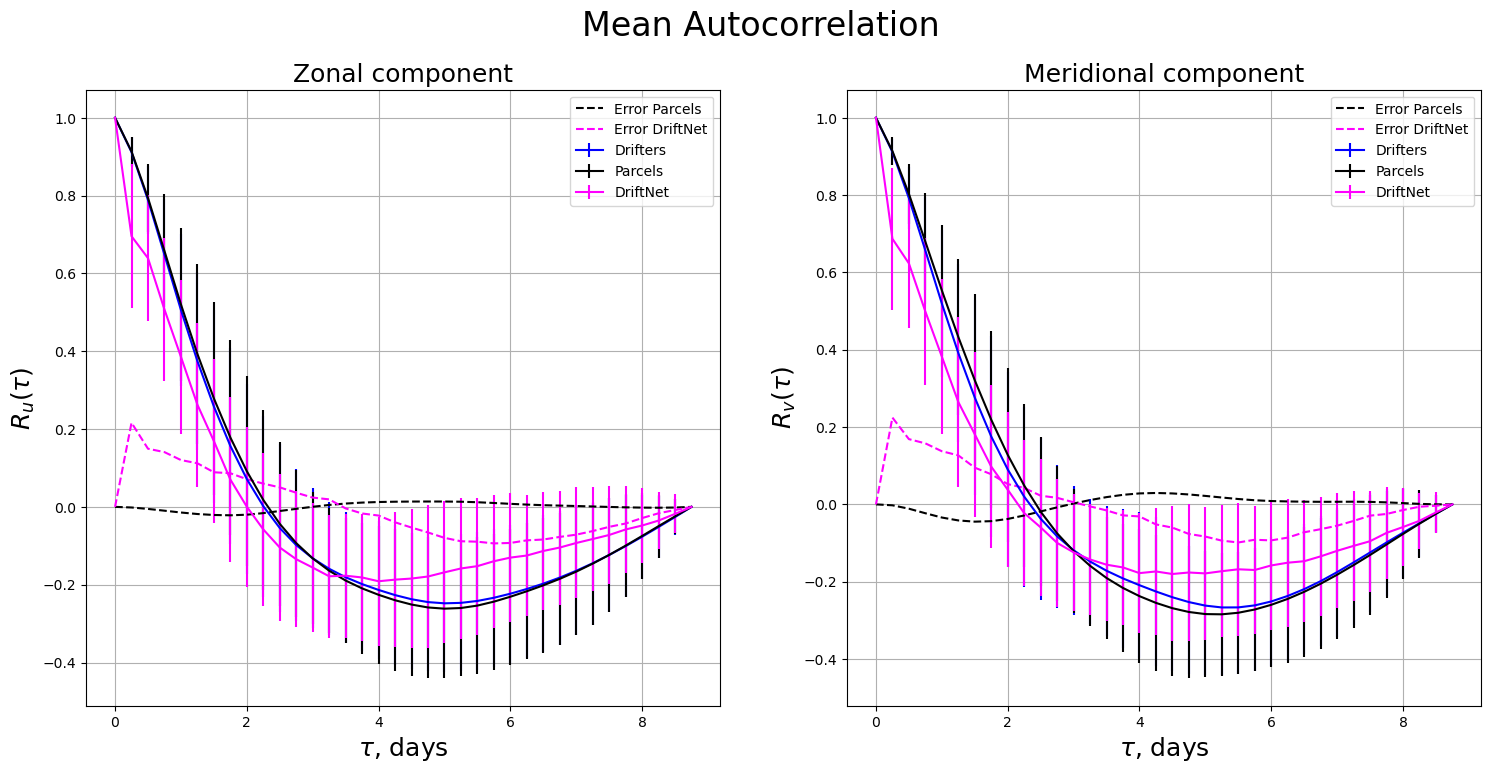

In [84]:
t = np.arange(0, 9, 0.25)

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('Mean Autocorrelation', fontsize=24)
#plt.plot(t, np.mean(R_u_real, axis = 0), label = 'real', color = 'green')
plt.title('Zonal component', fontsize=18)
#plt.errorbar(t, np.nanmean(R_u_sim, axis = 0),yerr =  np.nanstd(R_u_sim, axis = 0) , label = 'Generator', color = 'black')
plt.errorbar(t, np.nanmean(R_u_real, axis = 0), yerr =  np.nanstd(R_u_real, axis = 0) , label = 'Drifters', color = '#0000FF')
plt.errorbar(t, np.nanmean(R_u_parcels, axis = 0), yerr =  np.nanstd(R_u_parcels, axis = 0) , label = 'Parcels', color = 'black')
plt.errorbar(t, np.nanmean(R_u_sim, axis = 0),yerr =  np.nanstd(R_u_sim, axis = 0) , label = 'DriftNet', color = 'magenta')
#plt.errorbar(t, np.nanmean(R_u_sim_GLO14, axis = 0),yerr =  np.nanstd(R_u_sim_GLO14, axis = 0) , label = 'DriftNet DENSE', color = 'green')
plt.plot(t, np.nanmean(R_u_real, axis = 0) - np.nanmean(R_u_parcels, axis = 0), label = 'Error Parcels', linestyle = 'dashed', c = 'black')
plt.plot(t, np.nanmean(R_u_real, axis = 0) - np.nanmean(R_u_sim, axis = 0), label = 'Error DriftNet', linestyle = 'dashed', c = 'magenta')

#plt.plot(t, np.nanmean(R_u_sim_GLO14, axis = 0) - np.nanmean(R_u_parcels, axis = 0), label = 'Error DENSE', linestyle = 'dashed', c = 'black')

plt.grid()
plt.legend()
plt.xlabel(r'$\tau$, days', fontsize=18)
plt.ylabel(r'$R_{u}$($\tau$)', fontsize=18)
plt.subplot(1, 2, 2)
plt.title('Meridional component', fontsize=18)

#plt.plot(t, np.mean(R_v_real, axis = 0), label = 'real', color='green')
#plt.plot(t, np.mean(R_v_parcels, axis = 0), label = 'real', color='green')
plt.errorbar(t, np.nanmean(R_v_real, axis = 0), yerr =  np.nanstd(R_v_real, axis = 0) , label = 'Drifters', color = '#0000FF')
plt.errorbar(t, np.nanmean(R_v_parcels, axis = 0), yerr =  np.nanstd(R_v_parcels, axis = 0) , label = 'Parcels', color = 'black')
plt.errorbar(t, np.nanmean(R_v_sim, axis = 0), yerr =  np.nanstd(R_v_sim, axis = 0), label = 'DriftNet', color = 'magenta')
#plt.errorbar(t, np.nanmean(R_v_sim_GLO14, axis = 0), yerr =  np.nanstd(R_v_sim_GLO14, axis = 0), label = 'DriftNet DENSE', color = 'green')

plt.plot(t, np.nanmean(R_v_real, axis = 0) - np.nanmean(R_v_parcels, axis = 0), label = 'Error Parcels', linestyle = 'dashed', c = 'black')
plt.plot(t, np.nanmean(R_v_real, axis = 0) - np.nanmean(R_v_sim, axis = 0), label = 'Error DriftNet', linestyle = 'dashed', c = 'magenta')
#plt.plot(t, np.nanmean(R_v_sim_GLO14, axis = 0) - np.nanmean(R_v_parcels, axis = 0), label = 'Error DENSE', linestyle = 'dashed', c = 'black')


plt.xlabel(r'$\tau$, days', fontsize=18)
plt.ylabel(r'$R_{v}$($\tau$)', fontsize=18)
plt.grid()
plt.legend()
#plt.savefig(exp + '_Ru.png')
#plt.show()
#plt.close()

In [85]:
def diffusivity(R_sim, R_real, R_parc):
    t = np.arange(0, 9, 0.25)
    #print(t.size, R.size)
    
    R_sim = R_sim[:R_sim.shape[0]]
    R_real = R_real[:R_sim.shape[0]]
    result_sim = np.zeros(R_sim.shape[0])
    result_real = np.zeros(R_real.shape[0])
    result_parc = np.zeros(R_parc.shape[0])
    
    #T_real, T_sim = np.zeros(R_real.shape[0]), np.zeros(R_real.shape[0])
    for i in range(0, R_parc.shape[0]):
        zero_cross_sim = np.where((R_sim[i] < 0))[0][0]
        t = np.arange(0, zero_cross_sim, 1)
        result_sim[i] = integrate.simps(R_sim[i][:t.shape[0]], t)
        
        zero_cross_sim = np.where(((R_real[i] < 0)))[0][0]
        t = np.arange(0, zero_cross_sim, 1)        
        result_real[i] = integrate.simps(R_real[i][:t.shape[0]], t)
        
        zero_cross_sim = np.where(R_parc[i] < 0)[0][0]
        t = np.arange(0, zero_cross_sim, 1)
        result_parc[i] = integrate.simps(R_parc[i][:t.shape[0]], t)     
        
    result_sim = result_sim[result_sim > 0]
    result_real = result_real[result_real > 0]
    result_parc = result_parc[result_parc > 0]
    
    plt.figure(figsize=(12,8))
    #plt.title('Lagrangian T \n RMSE = ' + str( np.round( np.sqrt( np.mean( (result_sim[:int(result_real.shape[0])] - result_parc[:int(result_real.shape[0])]) ** 2 ) ) , 1) ) + ' days')
    plt.hist(result_real, label = 'Drifters', color='green')
    plt.hist(result_sim, label = 'Generator', color= '#FFB14E')
    #sb.distplot(result_real[:int(result_real.shape[0])], label = 'Drifters', color= 'green')
    #sb.distplot(result_parc[:int(result_sim.shape[0])], label = 'Parcels', color= '#0000FF')
    plt.title('Lagrangian Time Scales distribution')
    plt.grid()
    plt.xlabel('days')
    plt.legend()
    
    #plt.savefig(exp + '_T_lagr.png')
    #plt.show()
    #plt.close()    
    
    print('Mean Lagrangian Time scale for ground-truth trajectories :' + str(np.round(np.mean(result_real), 2)) + ' days')
    print('Mean Lagrangian Time scale for simulated trajectories :' + str(np.round(np.mean(result_sim), 2)) + ' days')
    print('Mean Lagrangian Time scale for Ocean Parcels trajectories :' + str(np.round(np.mean(result_parc), 2)) + ' days')
    '''
    print(np.mean(result_real), np.mean(result_sim), np.mean(result_parc))
    print('STD Lagrangian T for real particles vs cGAN :')
    print(np.std(result_real), np.std(result_sim), np.std(result_parc))
    '''
    '''
    print('RMSE between T_S and T_R')
    print(np.round( np.sqrt( np.mean( (result_sim[:int(np.minimum(result_sim.shape[0], result_real.shape[0]))] - result_real[:int(np.minimum(result_sim.shape[0], result_real.shape[0]))]) ** 2 ) ) , 1))
    print('RMSE between T_P and T_R')
    print(np.round( np.sqrt( np.mean( (result_real[:int(np.minimum(result_sim.shape[0], result_real.shape[0]))] - result_parc[:int(np.minimum(result_sim.shape[0], result_real.shape[0]))]) ** 2 ) ) , 1))
    '''
    
    return result_real, result_sim, result_parc

Mean Lagrangian Time scale for ground-truth trajectories :4.56 days
Mean Lagrangian Time scale for simulated trajectories :3.46 days
Mean Lagrangian Time scale for Ocean Parcels trajectories :4.66 days


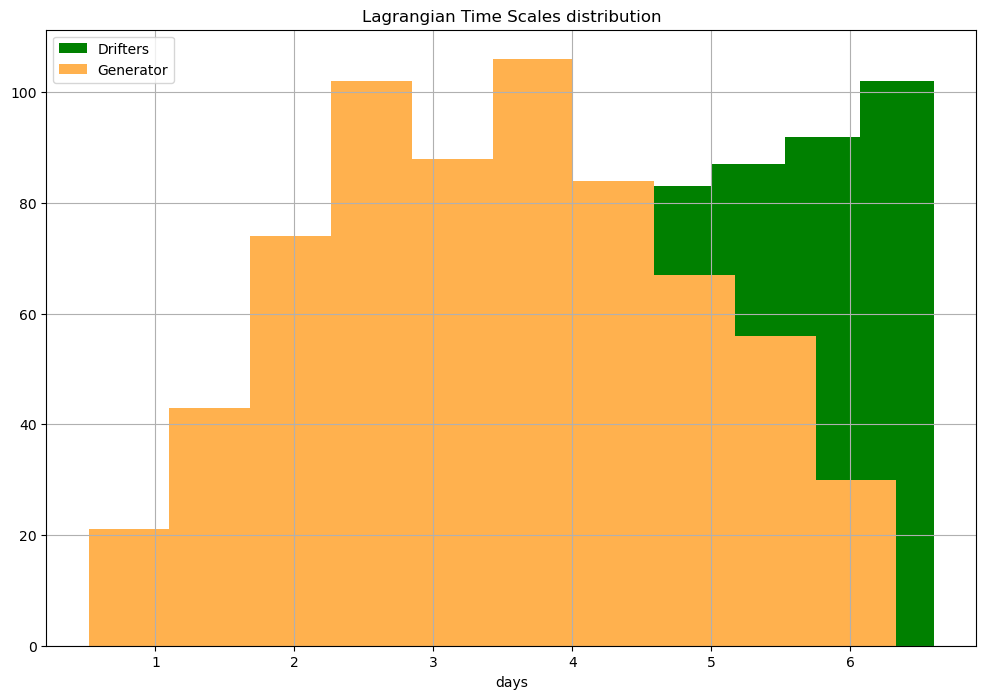

In [86]:
T_real, T_simulated, T_parcels = diffusivity(R_u_sim, R_u_real, R_u_parcels)

In [87]:
def LagrLiuIndex(trajR, trajS, trajP):
   
    ids = np.where(np.sum(trajP, axis = 2) == 0.)[0]
    
    
    trajR = np.delete(trajR, ids, axis = 0)
    trajS = np.delete(trajS, ids, axis = 0)
    trajP = np.delete(trajP, ids, axis = 0)
   
    sepDistancesRS = np.sqrt( (trajR[:,0, :] - trajS[:,0,:])** 2 + (trajR[:,1,:] - trajS[:,1,:])** 2 )
    SumSepDist = np.sum(sepDistancesRS, axis = 1)

    
    distances = np.sqrt(np.diff(trajR[:,0,:])**2 + np.diff(trajR[:,1,:])**2)
    distances = np.append(np.zeros((trajR.shape[0],1)), distances, 1)  # add 0 at first position

    
    cumsum = np.sum(np.cumsum(distances, axis = 1), axis = 1)
    
    liuIndex_R_S = SumSepDist / cumsum
    
    sepDistancesRP = np.sqrt( (trajR[:,0, :] - trajP[:,0,:])** 2 + (trajR[:,1,:] - trajP[:,1,:])** 2 )
    SumSepDist = np.sum(sepDistancesRP, axis = 1)
    liuIndex_R_P = SumSepDist / cumsum
    
    sepDistancesPS = np.sqrt( (trajS[:,0, :] - trajP[:,0,:])** 2 + (trajS[:,1,:] - trajP[:,1,:])** 2 )
    
    SumSepDist = np.nansum(sepDistancesPS, axis = 1)
    distancesP = np.sqrt(np.diff(trajP[:,0,:])**2 + np.diff(trajP[:,1,:])**2)
    distancesP = np.append(np.zeros((trajS.shape[0],1)), distancesP, 1)  # add 0 at first position
    
    cumsum = np.sum(np.cumsum(distancesP, axis = 1), axis = 1)
    
    liuIndex_P_S = SumSepDist / cumsum
    
    liuIndex_P_S_endpoint = sepDistancesPS[:,-1] / np.cumsum(distancesP, axis = 1)[:, -1]
    
    
    print('Mean Liu index between ground-truth and simulated trajectories :' + str(np.round(np.mean(liuIndex_R_S), 2)) + ' days')
    print('Mean Liu index between ground-truth and Ocean Parcels trajectories :' + str(np.round(np.mean(liuIndex_R_P), 2)) + ' days')
    print('Mean Liu index between simulated and Ocean Parcels trajectories :' + str(np.round(np.mean(liuIndex_P_S), 2)) + ' days')
    
   
    return liuIndex_R_S, liuIndex_R_P, liuIndex_P_S
    

In [88]:
liuIndex_R_S, liuIndex_R_P, liuIndex_P_S = LagrLiuIndex(traj_real, traj_sim, traj_parcels)

Mean Liu index between ground-truth and simulated trajectories :0.65 days
Mean Liu index between ground-truth and Ocean Parcels trajectories :0.87 days
Mean Liu index between simulated and Ocean Parcels trajectories :0.5 days


In [106]:
def plot(trajR, trajS, trajP, parcels, inds_rand, lst_curl, name, NatRun, N_trajs, Pacific, inds_zoomed_in):
    #plt.figure(figsize = (20,20))
    #fig, ax = plt.subplots(1, 1, figsize = (32,25))
    
    if(NatRun):
        if(Pacific):
            minX = - 148 #-3. #np.min(trajP[:,0,:])
            maxX = - 122 #3. #np.max(trajP[:,0,:])
            minY = 22 #-3. #np.min(trajP[:,1,:])
            maxY = 37 #3. #np.max(trajP[:,1,:])
        else:
            minX = - 80 #-3. #np.min(trajP[:,0,:])
            maxX = - 62 #3. #np.max(trajP[:,0,:])
    
            minY = 24 #-3. #np.min(trajP[:,1,:])
            maxY = 39 #3. #np.max(trajP[:,1,:])
            
    else:
        minX = - 150 #-3. #np.min(trajP[:,0,:])
        maxX = - 110 #3. #np.max(trajP[:,0,:])
    
        minY = 20 #-3. #np.min(trajP[:,1,:])
        maxY = 55 #3. #np.max(trajP[:,1,:])
    
    '''curl = xr.open_dataset("/home/daria/Documents/These/DATA/GLORYS_FIELDS/NAT_RUN_DRIFTERS/NatRun_3nadir/CURL/GLOBC/" +lst_curl[0])
    data_curl_vor = curl.vor.values
    data_curl_vor_new = np.concatenate((np.zeros((120, 4320)), data_curl_vor))'''
    data_curl = xr.open_dataset(files_curl[0])
    data_curl_vor = data_curl.vor.values
    data_curl_vor_new = np.concatenate((np.zeros((120, 4320)), data_curl_vor))
    #ax = plt.imshow(curl.vor.values, transform=ccrs.PlateCarree(), extent = [minX, maxX, minY, maxY], origin = "lower", cmap = cmocean.cm.curl, vmin = -0.0001, vmax = 0.0001)
    
    projection = ccrs.PlateCarree(central_longitude=-50.0)
    fig, ax = plt.subplots(1, 1, figsize = (65, 25), subplot_kw={'projection': projection, "aspect": 2}) #plt.figure(figsize = (30, 20))
    #
    #ax = plt.axes(projection = projection)
    ax0 = ax
    ax0.coastlines()
    ax0.set_extent([minX, maxX, minY, maxY], crs=ccrs.PlateCarree())
    gl = ax0.gridlines(draw_labels = True)
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': 30}
    gl.ylabel_style = {'size': 30}
    cm = ax0.imshow(data_curl_vor_new, origin='lower', transform=ccrs.PlateCarree(), cmap = cmocean.cm.curl, vmin = -0.0001, vmax = 0.0001)
    cbar = plt.colorbar(cm, fraction=0.022, pad=0.06)
    cbar.ax.tick_params(labelsize=34)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    cbar.ax.yaxis.offsetText.set(size=34)
    cbar.ax.set_ylabel(r'relative vorticity, $s^{-1}$', rotation = 270, labelpad = 55, fontsize = 40)
    
    if(NatRun):
        if(Pacific):
            xMin = -139
            xMax = -130
            yMin = 27
            yMax = 32
        else:
            xMin = -73
            xMax = -65
            yMin = 30
            yMax = 35
    else:
        xMin = -125
        xMax = -115
        yMin = 30
        yMax = 35
    
  
    ax0.set_title('(a)', fontsize = 45, y = 1.1)
    

    trajR_complete = trajR
    trajS_complete = trajS
    trajP_complete = trajP
    
    trajR = trajR#[inds_rand]
    trajS = trajS#[inds_rand]
    trajP = trajP#[inds_rand]
    
 
    for i in range(N_trajs):
        #print(i, trajP.shape)
        if(parcels==False):
            b, = ax0.plot(trajP[i,0,:], \
                     trajP[i,1,:], c = 'magenta', alpha = 0.6, label = 'parcels', linewidth = 6, transform=ccrs.PlateCarree())
            c, = ax0.plot(trajR[i,0,:], \
                     trajR[i,1,:], c = 'black', alpha = 0.6, label = 'drifters', linewidth = 6, transform=ccrs.PlateCarree())
            
        else : 
            c, = plt.plot(trajP[i,0,:], \
                     trajP[i,1,:], c = 'magenta', alpha = 0.6, label = 'Parcels', linewidth = 5)
        
        a, = ax0.plot(trajS[i,0,:], \
                 trajS[i,1,:], c = 'blue', label = 'generator', linewidth = 6, transform=ccrs.PlateCarree())
        
       
    if(NatRun):
        if(parcels == False):
            #plt.legend([c, b, a], ['Parcels(NatRun)', 'Parcels(NatRun3nadirs)', 'DriftNet(NatRun3nadirs)'], loc = 'upper left', bbox_to_anchor=(1., 1.), fontsize = 12, shadow = True, edgecolor='black')
            ax0.legend([c, b, a], ['Parcels(NatRun)', 'Parcels', 'DriftNet'], loc = 'upper left', bbox_to_anchor=(.7, 1.), fontsize = 34, shadow = True, edgecolor='black')
        else :         
            ax0.legend([a, c], ['DriftNet(NatRun3nadirs)', 'Parcels(NatRun3nadirs)'], loc = 'upper left', bbox_to_anchor=(1., 1.), fontsize = 34, shadow = True, edgecolor='black')
    else:
        ax0.legend([c, b, a], ['Drifters', 'Parcels', 'DriftNet'], loc = 'upper left', bbox_to_anchor=(.7, 1.), shadow = True, edgecolor='black', fontsize = 30)
       
    return inds_rand

[1, 2, 3, 4]

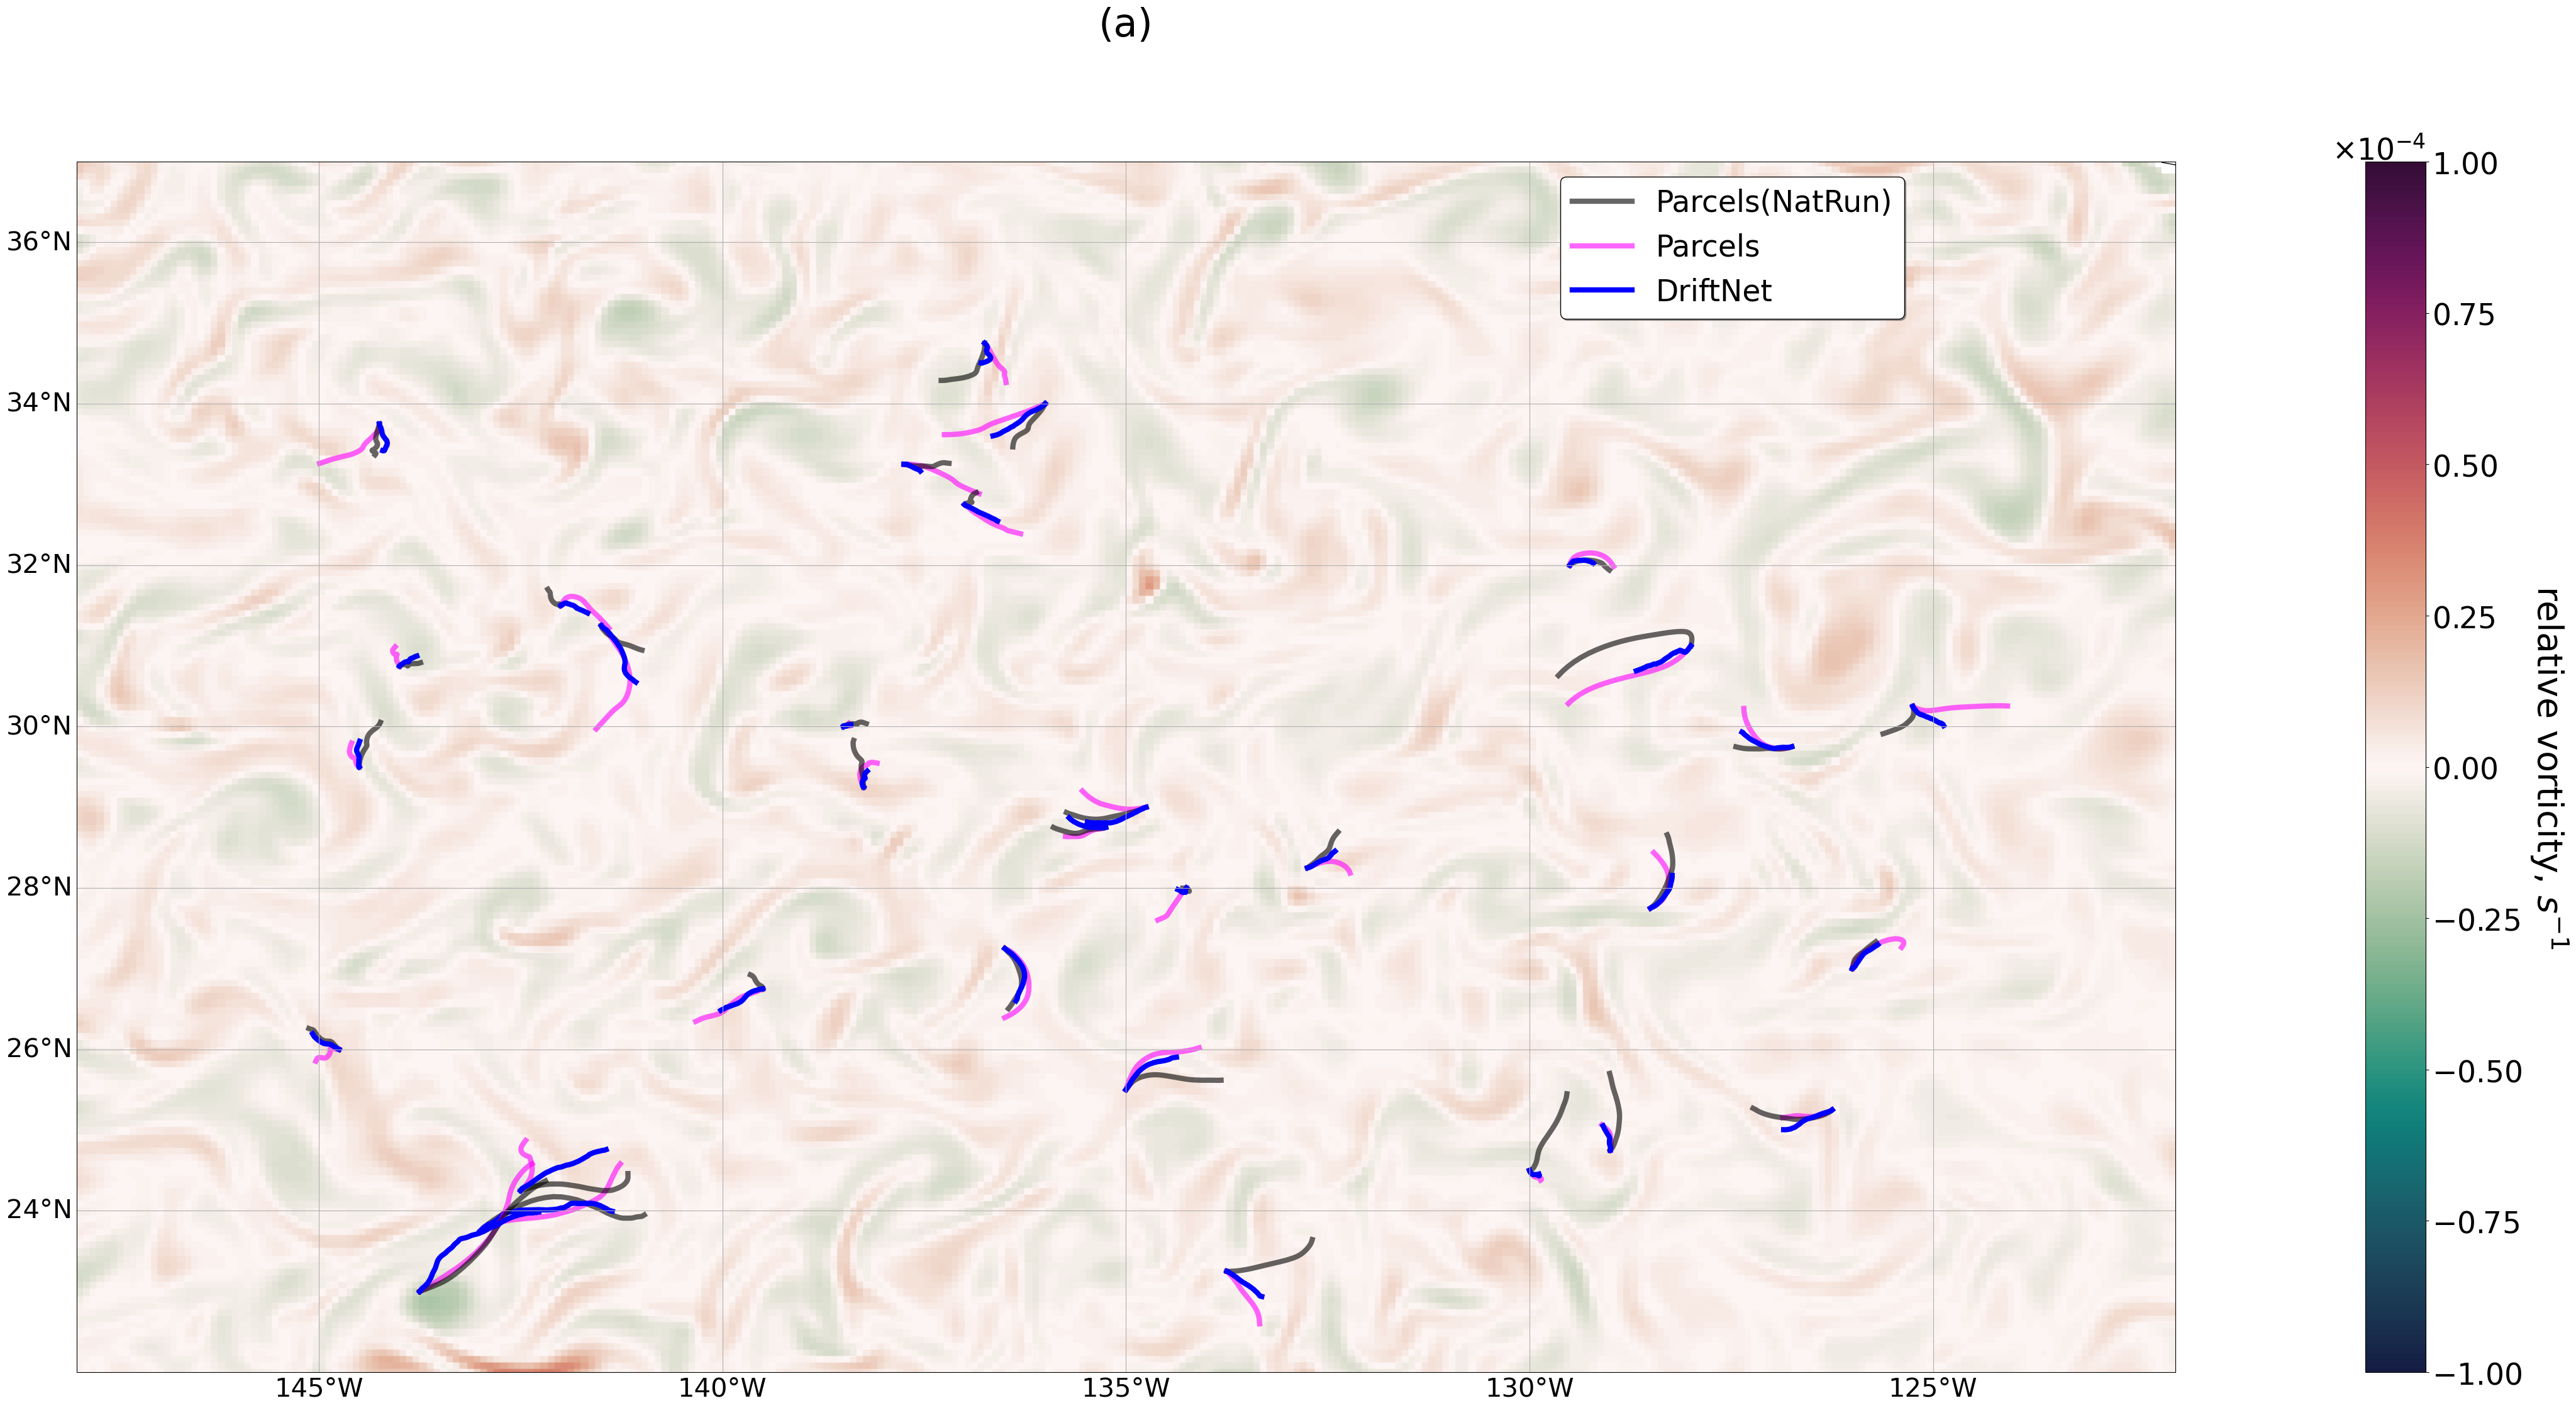

In [107]:
plot(traj_real, traj_sim, traj_parcels, False, [1, 2, 3, 4], lst_curl, '', True, 32, True, [])


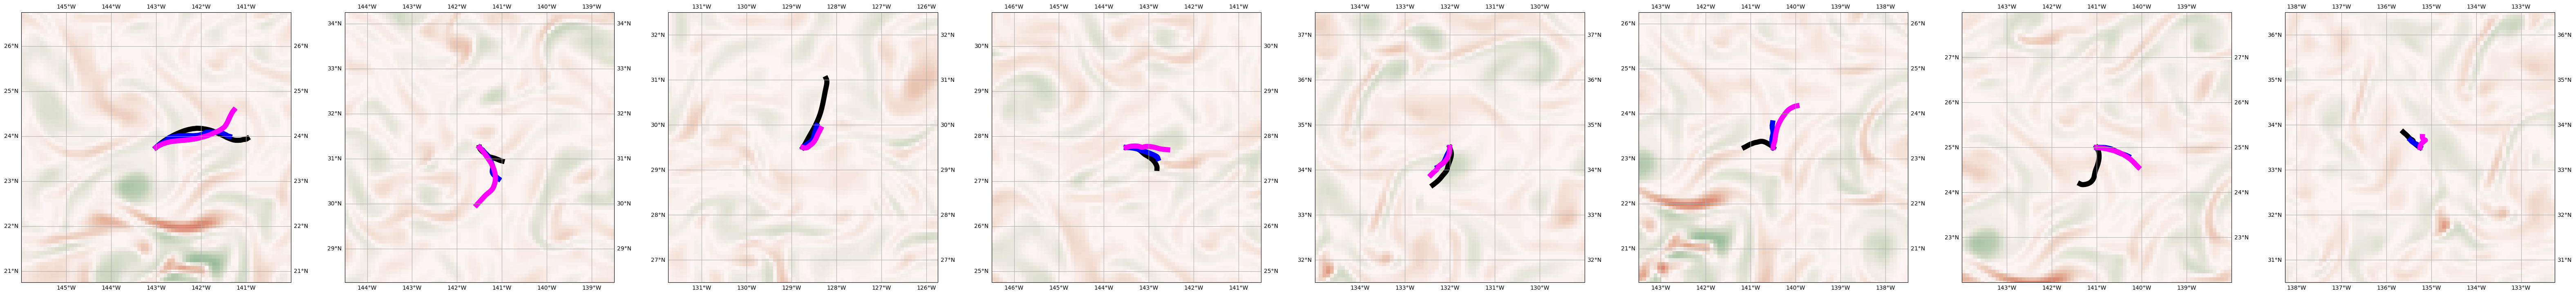

In [109]:
proj = ccrs.PlateCarree(central_longitude=-50)

N_pixels_delta = 3

fig, ax = plt.subplots(1, 8, figsize = (80, 20), subplot_kw={'projection': proj, "aspect": 2}, gridspec_kw = {'wspace':0.2, 'hspace':0.007},)
#plt.title('(b)', transform = ccrs.PlateCarree())
for j, i in enumerate(range(8*30)[::30]):
    ax[j].set_extent([traj_real[i, 0, 0] - N_pixels_delta , traj_real[i, 0, 0] + N_pixels_delta ,\
                      traj_real[i, 1, 0] - N_pixels_delta , traj_real[i, 1, 0] + N_pixels_delta ], crs=ccrs.PlateCarree())
    ax[j].coastlines()
    ax[j].gridlines(draw_labels = True)
    ax[j].imshow(data_curl_vor_new, transform=ccrs.PlateCarree(), origin = "lower", cmap = cmocean.cm.curl, vmin = -0.0001, vmax = 0.0001)
    ax[j].plot(traj_real[i, 0], traj_real[i, 1], c = 'black', transform=ccrs.PlateCarree(), linewidth = 9)
    ax[j].plot(traj_sim[i, 0], traj_sim[i, 1], c = 'blue', transform=ccrs.PlateCarree(), linewidth = 9)
    ax[j].plot(traj_parcels[i, 0], traj_parcels[i, 1], c = 'magenta', transform=ccrs.PlateCarree(), linewidth = 9)
